# Run inference on pre-trained model:

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from tqdm.auto import tqdm


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from grace.base import GraphAttrs, Annotation

from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor

from grace.models.datasets import dataset_from_graph
# from grace.models.classifier import GCN
from grace.models.optimiser import optimise_graph
from grace.simulator.simulate_graph import random_graph

from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components,
)

from grace.evaluation.process import (
    generate_ground_truth_graph,
    update_graph_with_dummy_predictions,
    assume_annotations_from_dummy_predictions,
    # assume_dummy_predictions_from_annotations,
    # add_and_remove_random_edges,
)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_ge

### Read some real grace-annotated data:

In [3]:
extractor_filename = "/Users/kulicna/Desktop/classifier/extractor/resnet152.pt"
pre_trained_resnet = torch.load(extractor_filename)
feature_extractor = FeatureExtractor(model=pre_trained_resnet)


In [4]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/train"
dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    transform=feature_extractor,
    keep_unknown_labels=False
)
image, graph_data = dataset[1]

G = graph_data["graph"]
image = image.numpy()
annot = graph_data["annotation"]
G.number_of_nodes(), G.number_of_edges(), annot.shape, image.shape 

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(178, 515, (3724, 3724), (3724, 3724))

### Visualise the data:

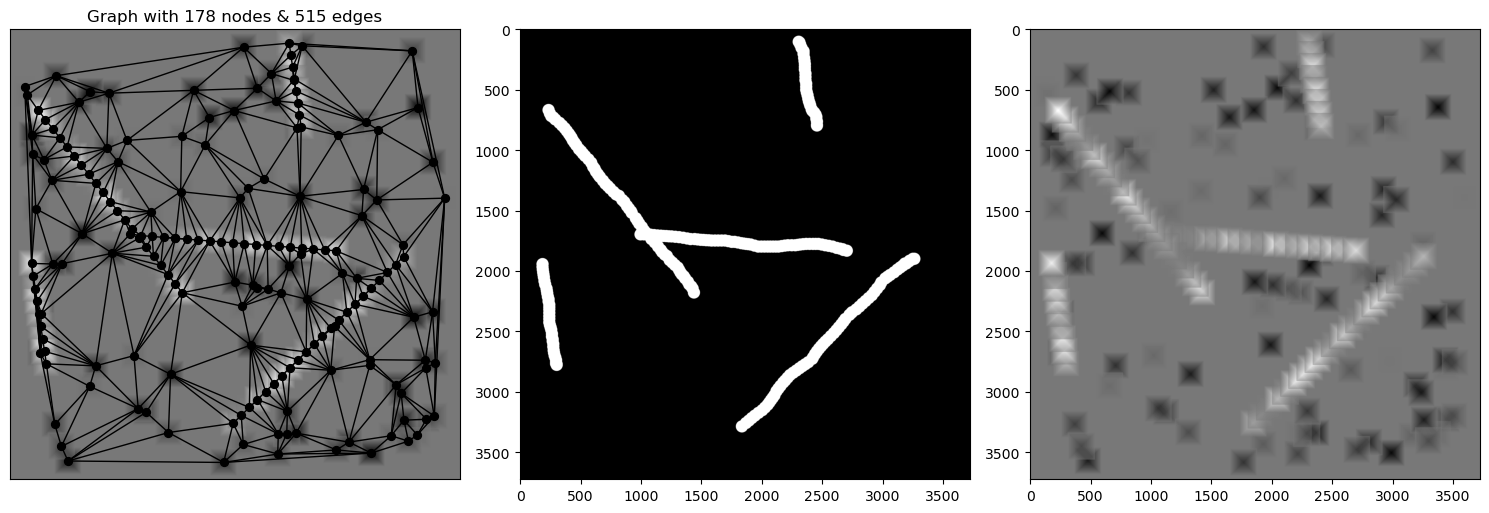

In [5]:
shape = 5
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Graph with {G.number_of_nodes()} nodes & {G.number_of_edges()} edges", ax=axes[0])
axes[0].imshow(image, cmap="binary_r")
axes[1].imshow(annot, cmap="binary_r")
axes[2].imshow(image, cmap="binary_r")

plt.tight_layout()
plt.show()

### Features are now automatically appended to the image:

In [6]:
for idx, node in G.nodes(data=True):
    print (node[GraphAttrs.NODE_FEATURES])
    break


tensor([0.8019, 0.4768, 0.8850,  ..., 0.3630, 0.3649, 0.3899])


In [7]:
data_whole_graph = dataset_from_graph(G, mode="whole")
data_whole_graph

Data(x=[178, 2048], edge_index=[2, 515], y=[178], pos=[178, 2], edge_label=[515])

### Nominate a pre-trained GCN model:

In [42]:
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-07-08/classifier.pt"
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-15-47/classifier.pt"
classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-30-51/classifier.pt"

pre_trained_gcn = torch.load(classifier_filename)
pre_trained_gcn.eval()


GCN(
  (node_classifier): Linear(in_features=2048, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=4096, out_features=2, bias=True)
)

### Get the predictions:

In [43]:
node_softmax_preds = []
edge_softmax_preds = []
node_argmax_preds = []
edge_argmax_preds = []
node_labels = []
edge_labels = []


# Predict labels from sub-graph:
node_x, edge_x = pre_trained_gcn.predict(
    x=data_whole_graph.x, 
    edge_index=data_whole_graph.edge_index
)
print (node_x.shape, edge_x.shape)

# Process nodes probs into classes predictions:
node_labels.extend(data_whole_graph.y)

# node_soft = softmax(node_x, dim=1)
node_soft = node_x.softmax(dim=1)
node_softmax_preds.extend(node_soft)

node_arg = node_soft.argmax(dim=1).long()
node_argmax_preds.extend(node_arg)

# Process nodes probs into classes predictions:
edge_labels.extend(data_whole_graph.edge_label)

# edge_soft = softmax(edge_x, dim=1)
edge_soft = edge_x.softmax(dim=1)
edge_softmax_preds.extend(edge_soft)

edge_arg = edge_soft.argmax(dim=1).long()
edge_argmax_preds.extend(edge_arg)


# Stack the results:
node_softmax_preds = torch.stack(node_softmax_preds, axis=0)
edge_softmax_preds = torch.stack(edge_softmax_preds, axis=0)
node_argmax_preds = torch.stack(node_argmax_preds, axis=0)
edge_argmax_preds = torch.stack(edge_argmax_preds, axis=0)
node_labels = torch.stack(node_labels, axis=0)
edge_labels = torch.stack(edge_labels, axis=0)

node_softmax_preds.shape, node_argmax_preds.shape, node_labels.shape

torch.Size([178, 2]) torch.Size([515, 2])


(torch.Size([178, 2]), torch.Size([178]), torch.Size([178]))

In [44]:
# node_softmax_preds = []
# edge_softmax_preds = []
# node_argmax_preds = []
# edge_argmax_preds = []
# node_labels = []
# edge_labels = []


# for data in tqdm(data_whole_graph, desc="Predicting for individual subgraphs: "):

#     # Predict labels from sub-graph:
#     result = pre_trained_gcn.predict(x=data.x, edge_index=data.edge_index)
#     node_emb, edge_emb, node_x, edge_x = result
#     print (data)
#     print ([r.shape for r in result])

#     # Process nodes probs into classes predictions:
#     node_labels.extend(data.y)
    
#     # node_soft = softmax(node_x, dim=1)
#     node_soft = node_x.softmax(dim=1)
#     node_softmax_preds.extend(node_soft)

#     node_arg = node_soft.argmax(dim=1).long()
#     node_argmax_preds.extend(node_arg)

#     # Process nodes probs into classes predictions:
#     edge_labels.extend(data.edge_label)
    
#     # edge_soft = softmax(edge_x, dim=1)
#     edge_soft = edge_x.softmax(dim=1)
#     edge_softmax_preds.extend(edge_soft)

#     edge_arg = edge_soft.argmax(dim=1).long()
#     edge_argmax_preds.extend(edge_arg)

#     # break

# # Stack the results:
# node_softmax_preds = torch.stack(node_softmax_preds, axis=0)
# edge_softmax_preds = torch.stack(edge_softmax_preds, axis=0)
# node_argmax_preds = torch.stack(node_argmax_preds, axis=0)
# edge_argmax_preds = torch.stack(edge_argmax_preds, axis=0)
# node_labels = torch.stack(node_labels, axis=0)
# edge_labels = torch.stack(edge_labels, axis=0)

# node_softmax_preds.shape, node_argmax_preds.shape, node_labels.shape

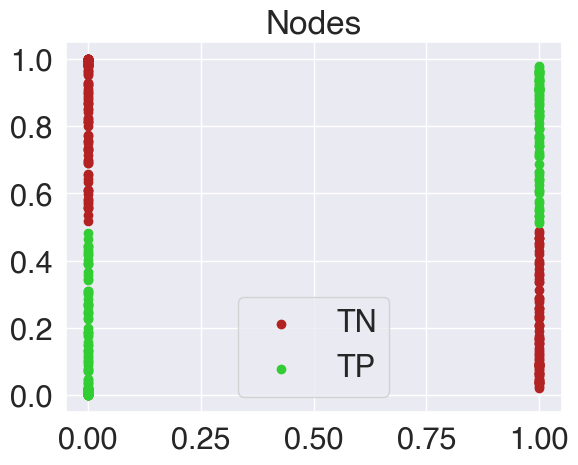

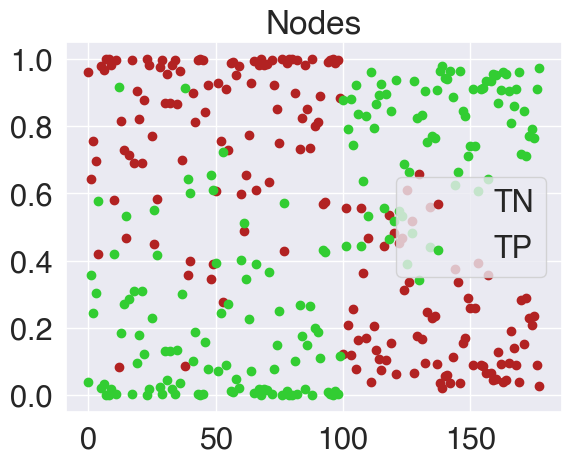

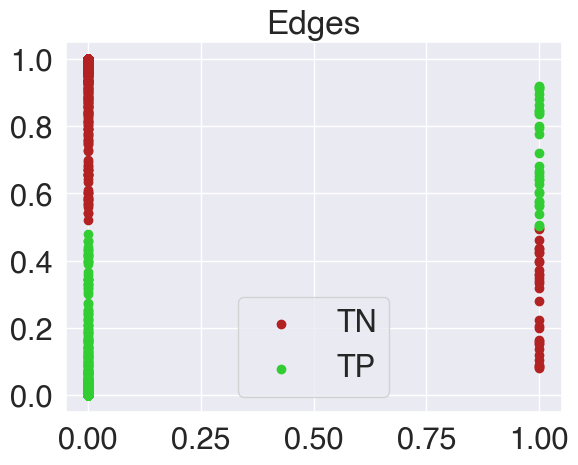

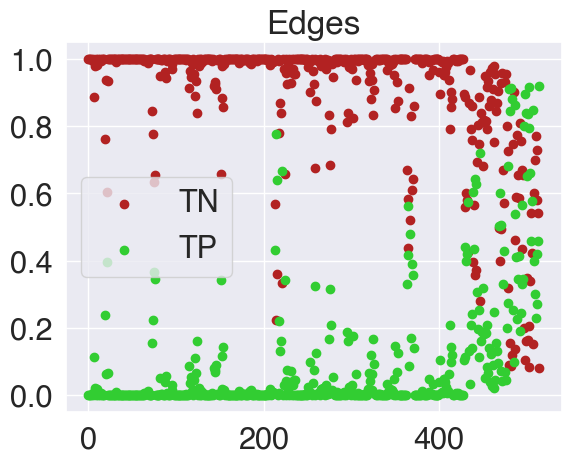

In [45]:
# investigate

plt.scatter(x=node_argmax_preds, y=node_softmax_preds[:, 0], color='firebrick', label='TN')
plt.scatter(x=node_argmax_preds, y=node_softmax_preds[:, 1], color='limegreen', label='TP')
plt.title("Nodes")
plt.legend()
plt.show()

plt.scatter(x=range(node_softmax_preds.shape[0]), y=node_softmax_preds[:, 0], color='firebrick', label='TN')
plt.scatter(x=range(node_softmax_preds.shape[0]), y=node_softmax_preds[:, 1], color='limegreen', label='TP')
plt.title("Nodes")
plt.legend()
plt.show()


plt.scatter(x=edge_argmax_preds, y=edge_softmax_preds[:, 0], color='firebrick', label='TN')
plt.scatter(x=edge_argmax_preds, y=edge_softmax_preds[:, 1], color='limegreen', label='TP')
plt.title("Edges")
plt.legend()
plt.show()

plt.scatter(x=range(edge_softmax_preds.shape[0]), y=edge_softmax_preds[:, 0], color='firebrick', label='TN')
plt.scatter(x=range(edge_softmax_preds.shape[0]), y=edge_softmax_preds[:, 1], color='limegreen', label='TP')
plt.title("Edges")
plt.legend()
plt.show()


## Evaluation:
### Simple metrics first:

In [46]:
from grace.evaluation.metrics_classifier import (
    accuracy_metric, 
    confusion_matrix_metric, 
    areas_under_curves_metrics,
)

In [47]:
node_acc, edge_acc = accuracy_metric(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels
)
node_acc, edge_acc

(0.9269662921348315, 0.8466019417475729)

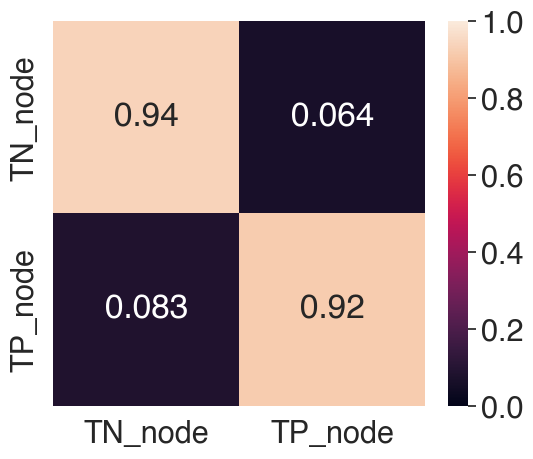

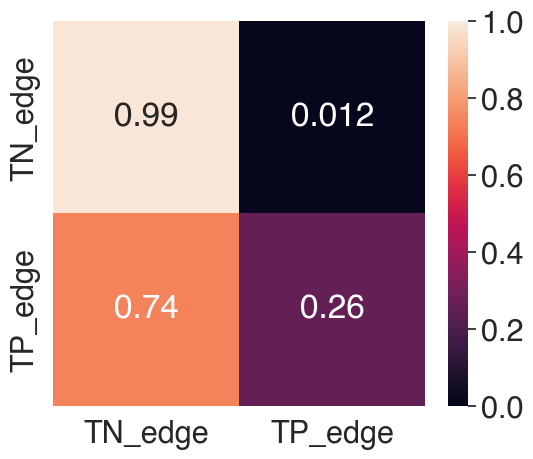

In [48]:
n_cm, e_cm = confusion_matrix_metric(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels, normalize="true"
)

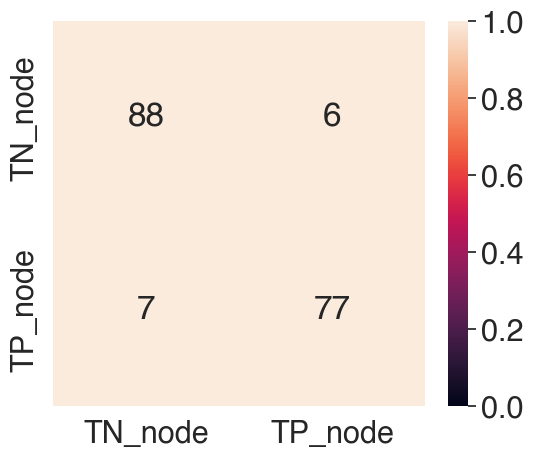

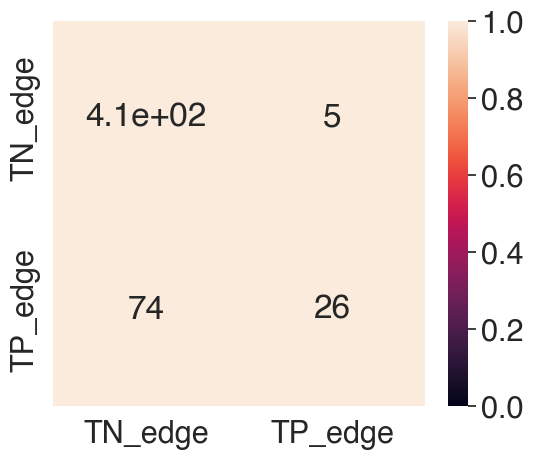

In [49]:
n_cm, e_cm = confusion_matrix_metric(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels, normalize=None
)

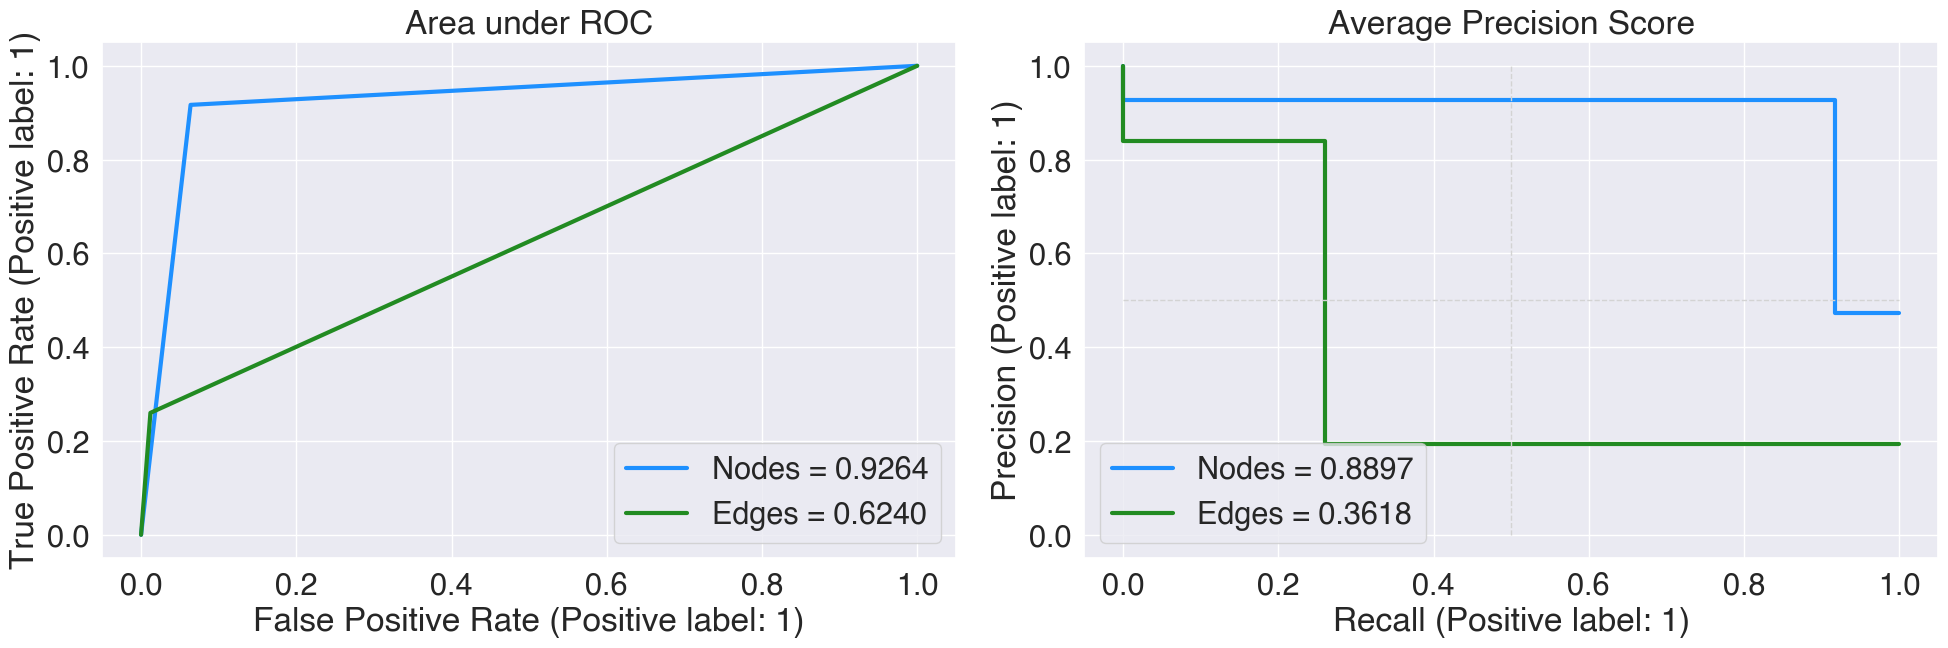

In [50]:
areas_fig = areas_under_curves_metrics(
    node_argmax_preds, edge_argmax_preds, node_labels, edge_labels
)

### Possibly, display all 4 confusion matrices:

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

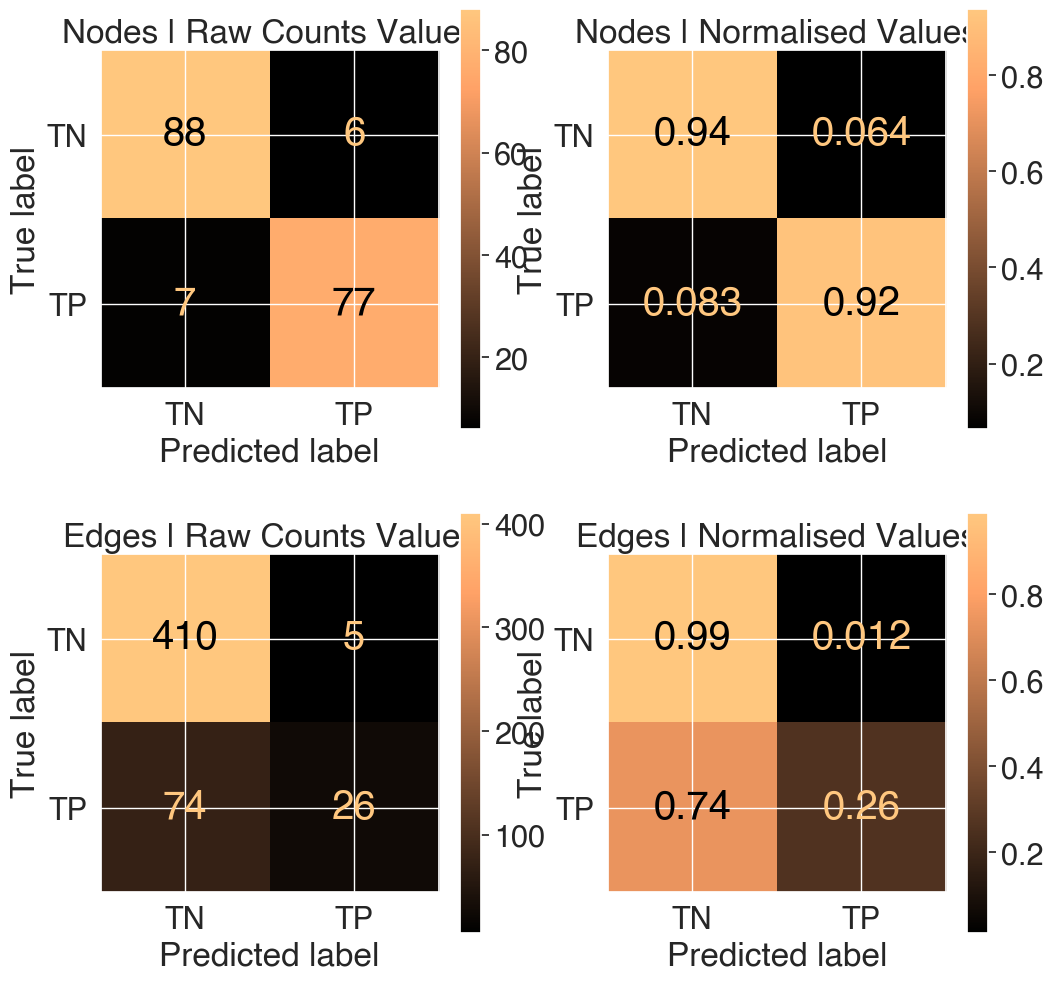

In [52]:
figsize = (12, 12)
colormap = "copper"
confusion_matrix_plotting_data = [
    [node_argmax_preds, node_labels, "nodes"], 
    [edge_argmax_preds, edge_labels, "edges"],
]

_, axs = plt.subplots(2, 2, figsize=figsize)

for d, matrix_data in enumerate(confusion_matrix_plotting_data):
    for n, nrm in enumerate([None, "true"]):
        ConfusionMatrixDisplay.from_predictions(
            y_pred=matrix_data[0],
            y_true=matrix_data[1],
            normalize=nrm,
            ax=axs[d, n],
            cmap=colormap,
            display_labels=["TN", "TP"],
            text_kw={"fontsize": "large"},
        )

        flag = "Raw Counts" if nrm is None else "Normalised"
        text = f"{matrix_data[2].capitalize()} | {flag} Values"
        axs[d, n].set_title(text)

plt.show()


##### Done!